# Test Pix2Struct model on UI2Code dataset

## Setup Envirnoment

In [ ]:
!pip install transformers==4.33.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.4 MB/s eta 0:00:00


## Import necessary libraries

In [ ]:
from google.colab import drive
import os
import zipfile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import re
from transformers import Pix2StructForConditionalGeneration, AutoProcessor
import torch
from torch.nn import functional as F
from pathlib import Path
from nltk import edit_distance
import numpy as np
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from torch.utils.data import random_split
import random
from transformers import GenerationConfig

## Define variables and parameters

In [ ]:
G_DRIVE_FOLDER = '/content/drive/MyDrive/Datasets/'
G_DRIVE_FOLDER_CHECKPOINTS = '/content/drive/MyDrive/Checkpoints/'
DATASET_NAME = 'ui2code_10000'
ZIP_NAME = DATASET_NAME + '.zip'
DESTINATION_FOLDER= '/content/data/'
DATASET_FOLDER = DESTINATION_FOLDER + DATASET_NAME # unzipped name is output
OUTPUT_FOLDER = '/content/drive/MyDrive/Testing_output/ui2code_10000'

EXPERIMENT_NAME = "Pix2Struct_UI2Code_Complete_3_TEST"

MAX_SENTENCE_LEN = 512

MAX_PATCHES = 1024

DEBUG = False
VERBOSE = True

BATCH_SIZE = 10
TRAIN_SET_PERCENTAGE = 0.898
VALID_SET_PERCENTAGE = 0.002 # Use 20 samples for validation
# TEST_SET_PERCENTAGE is 1 - TRAIN_SET_PERCENTAGE - VALID_SET_PERCENTAGE # Use 1000 for test

RANDOM_SEED = 100

LOAD_FROM_CHECKPOINT = True
LAST_CHECKPOINT_NAME = "Pix2Struct_UI2Code_Complete_3_epoch[9].pth"

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Load UI2Code Dataset

### Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Import zip file from Google Drive

In [ ]:
os.makedirs(DESTINATION_FOLDER, exist_ok=True)

with zipfile.ZipFile(G_DRIVE_FOLDER + ZIP_NAME, "r") as zf:
    zf.extractall(DESTINATION_FOLDER)

## Load Model and Processor

In [ ]:
repo_id = "google/pix2struct-base"

processor = AutoProcessor.from_pretrained(repo_id)
model = Pix2StructForConditionalGeneration.from_pretrained(repo_id, is_encoder_decoder=True)

(…)se/resolve/main/preprocessor_config.json:   0%|          | 0.00/231 [00:00<?, ?B/s]

(…)-base/resolve/main/tokenizer_config.json:   0%|          | 0.00/2.61k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

(…)2struct-base/resolve/main/tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

(…)ase/resolve/main/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

(…)pix2struct-base/resolve/main/config.json:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

## Create Dataset class

## Load list of files and display some of them

In [ ]:
all_paths = [filename.split(".txt")[0] for filename in os.listdir(DATASET_FOLDER) if filename.endswith(".txt")]

In [ ]:
len(all_paths)

10000

In [ ]:
with open(DATASET_FOLDER + "/" + all_paths[0] + ".txt", "r") as f:
    print(f.read())

android.support.v4.widget.DrawerLayout { android.widget.LinearLayout { android.widget.LinearLayout { android.widget.FrameLayout android.widget.LinearLayout { android.widget.LinearLayout { android.widget.TextView } android.widget.TextView android.widget.ImageButton android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.MultiAutoCompleteTextView android.widget.ImageView android.widget.ImageView } } } }


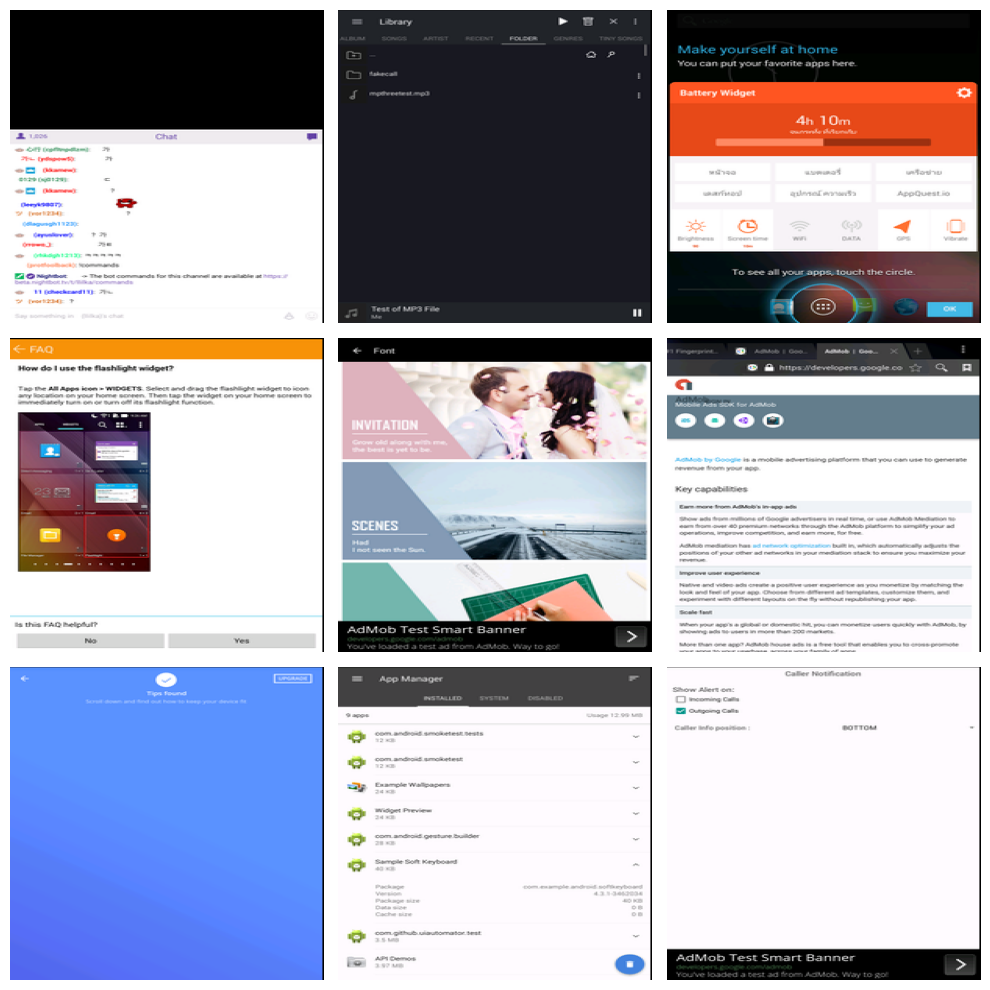

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Create a new figure
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Iterate through the image paths and plot them
for i, path in enumerate(all_paths[:9]):
    img = Image.open(DATASET_FOLDER + "/" + path + ".png")
    img_rotated = img.rotate(-90, expand=1)  # rotating image 90 degrees clockwise

    ax = axs[i // 3, i % 3]
    ax.imshow(img_rotated)
    ax.axis("off")
    ax.set_aspect('auto')
plt.tight_layout()
plt.show()


### Find max sentence length and new unknown tokens, filter files bigger than max sentence len

In [ ]:
# Find max length
max_length = 0
filtered_paths = []

# Read text files and add new tokens to dictionary
tokens_to_add = set()
for path in tqdm(all_paths):
    with open(DATASET_FOLDER + "/" + path + ".txt", "r") as f:
        content = f.read()
        splitted_text = processor.tokenizer(content).tokens()
    # Check if the current sentence has the largest number of tokens
    if len(splitted_text) > max_length:
        max_length = len(splitted_text)

    if len(splitted_text) <= MAX_SENTENCE_LEN:
        filtered_paths.append(path)
        tokens_to_add = tokens_to_add.union(set(splitted_text))

print(f"Max sentence length = {max_length}")

newly_added_num = processor.tokenizer.add_tokens(list(tokens_to_add))
print(f"Number of new tokens = {newly_added_num}")

# Resize the model's token embeddings if there are new tokens
if newly_added_num > 0:
    model.decoder.resize_token_embeddings(len(processor.tokenizer), pad_to_multiple_of=8)

100%|██████████| 10000/10000 [00:03<00:00, 2786.43it/s]


Max sentence length = 444
Number of new tokens = 12


In [ ]:
# Keep only the samples with number of tokens lower than Max Sentence Length
all_paths = filtered_paths

In [ ]:
random.seed(RANDOM_SEED)

# Use the same seed, so that parts remain the same
random.shuffle(all_paths)

train_len = int(TRAIN_SET_PERCENTAGE * len(all_paths))
valid_len = int(VALID_SET_PERCENTAGE * len(all_paths))

train_paths = all_paths[:train_len]
valid_paths = all_paths[train_len:train_len+valid_len]
test_paths = all_paths[train_len+valid_len:]

print(f"TRAIN_SET size = {len(train_paths)}")
print(f"VALID_SET size = {len(valid_paths)}")
print(f"TEST_SET size = {len(test_paths)}")

TRAIN_SET size = 8980
VALID_SET size = 20
TEST_SET size = 1000


In [ ]:
class UI2CodeDataset(Dataset):
    # This is a modification of the dataset used for validation and testing
    # In this one the sentences are already split into chunks, already having
    # the context from the previous chunk, empty chunks are discarded
    def __init__(self, root_dir, transform, paths):

        self.root_dir = root_dir
        self.transform = transform
        self.paths = paths

        self.max_patches = MAX_PATCHES
        self.max_length = MAX_SENTENCE_LEN
        self.ignore_id = -100

        self.encodings = []

        for path in tqdm(paths):
            # Directly process the text files, and save them in the ram
            # Do the same also for images, if there is enough space in memory
            text_file_path = os.path.join(root_dir, path + ".txt")
            image_file_path = os.path.join(root_dir , path + ".png")

            # Each data entry has the following structure
            # labels, image_encoding_idx, part

            # image_encoding_idx points to an entry of images_encoding, which contains attention_mask and flattened_patches for the image
            # Since a single image is used for multiple slices of the same text, this approach is used to save memory

            # Load image
            # Load image
            image = Image.open(image_file_path).convert('RGB')
            image = image.rotate(-90, expand=1)


            if DEBUG:
                image.show()

            if self.transform:
                image = self.transform(image)

            encoding = processor(images=image, max_patches=self.max_patches, return_tensors="pt")
            encoding = {k:v.squeeze() for k,v in encoding.items()}

            # Load text
            with open(text_file_path, "r") as f:
                text_content = f.read()

            input_ids = processor.tokenizer(
                text_content,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            ).input_ids

            labels = input_ids.squeeze().clone()
            labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token

            encoding["labels"] = labels

            # For each sample save directly the encoding of both text and image
            self.encodings.append(encoding)

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        return self.encodings[idx], self.paths[idx]

In [ ]:
# Transformations for the image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalize for pretrained models
])

# Instantiate the CustomDataset
test_dataset = UI2CodeDataset(DATASET_FOLDER, transform, test_paths)

# Use DataLoader for batching and shuffling
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 1000/1000 [00:14<00:00, 70.07it/s]


In [ ]:
print(f"test_dataloader size = {len(test_dataloader)}")

test_dataloader size = 100


In [ ]:
batch = next(iter(test_dataloader))

In [ ]:
encoding, text_file_paths = batch

In [ ]:
print(text_file_paths)

('53ce300c22413732798b963bd26fb368e620850709e1e310b60af82d', 'b240d214d12082c2b12d3dd9bcba3e90a51320a1d18a48a1cfec50bb', '0ce5976af270dd2d781dbba4a257392cc6c3138baf6a8dd993162dde', '8ab828209b71e34206bc6174b593f661bf847ad584f7101221dfcc0c', '048deb9ee944d13bf456e2f3034e7feac8e4400e35c8e66ed06e62ad', '311e82d9479b11147dba5e6f59f7d72853c6b30bc158b5573529b472', '689822c798d112863a86ab2d26b317220cbb44aa8a55289a6e412957', '16010bd2e74bfa1479b633c064829e9cb22e68cd959ba578bad0735b', 'acb9cd75bea09cae1ef1e2ad2f487262c9068f0ad46015f77c449181', '085afeb6e08bd736a4a89d435530860964d13c2e3648011b1e35c5cf')


In [ ]:
encoding

{'flattened_patches': tensor([[[ 1.0000e+00,  1.0000e+00, -8.9484e+00,  ..., -2.2677e-01,
            1.3207e-01,  5.5434e-01],
          [ 1.0000e+00,  2.0000e+00, -8.9484e+00,  ..., -2.2677e-01,
            1.3207e-01,  5.5434e-01],
          [ 1.0000e+00,  3.0000e+00, -8.9484e+00,  ..., -2.2677e-01,
            1.3207e-01,  5.5434e-01],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 1.0000e+00,  1.0000e+00, -1.7556e+00,  ..., -1.6591e-01,
           -5.6904e-02,  4.8289e-02],
          [ 1.0000e+00,  2.0000e+00, -1.7556e+00,  ...,  1.0021e-02,
            1.1394e-01,  2.3206e-01],
          [ 1.0000e+00,  3.0000e+00, -1.7556e+00,  ..., -2.2161e-01,
           -1.0795e-01,  2.3012e-03]

In [ ]:
encoding["flattened_patches"][0]

tensor([[ 1.0000,  1.0000, -8.9484,  ..., -0.2268,  0.1321,  0.5543],
        [ 1.0000,  2.0000, -8.9484,  ..., -0.2268,  0.1321,  0.5543],
        [ 1.0000,  3.0000, -8.9484,  ..., -0.2268,  0.1321,  0.5543],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
encoding["labels"]

tensor([[ 3550,   274, 13717,  ...,  -100,  -100,  -100],
        [ 3550,   274, 13717,  ...,  -100,  -100,  -100],
        [ 3550,   274,  4060,  ...,  -100,  -100,  -100],
        ...,
        [ 3550,   274, 13717,  ...,  -100,  -100,  -100],
        [ 3550,   274, 10412,  ...,  -100,  -100,  -100],
        [ 3550,   274, 13717,  ...,  -100,  -100,  -100]])

In [ ]:
encoding["labels"][0]

tensor([ 3550,   274, 13717,   274,  6118,  3920,  3550,   274, 13717,   274,
        29301,  3550,   274, 10412,   274,   703,   295,   274, 13717,   274,
         6754, 22855,   574,  3920,   435,  3550,   274, 13717,   274, 43727,
        18191, 13142,   435,  3550,   274, 13717,   274, 29301,  3550,   274,
        13717,   274, 29301,  3550,   274, 13717,   274, 29301,  3550,   274,
        13717,   274, 48251, 29301,   512,  3550,   274, 13717,   274, 43727,
        18191, 13142,   435,  3550,   274, 13717,   274, 29301,  3550,   274,
        13717,   274, 29301,  3550,   274, 13717,   274, 29301,  3550,   274,
        13717,   274, 48251, 29301,   512,   512,  3550,   274, 13717,   274,
        10446, 13142,   435,  3550,   274, 13717,   274, 29301,   512,  3550,
          274, 13717,   274, 10446, 13142,   435,  3550,   274, 13717,   274,
        29301,   512,  3550,   274, 13717,   274, 10446, 13142,   435,  3550,
          274, 13717,   274, 29301,   512,  3550,   274, 13717, 

In [ ]:
labels_list = encoding["labels"][0].tolist()

# Filter out the -100 values
filtered_labels = [token for token in labels_list if token != -100]

# Decode the cleaned list of tokens
decoded_text_example = processor.tokenizer.batch_decode([filtered_labels], skip_special_tokens=True)[0]


In [ ]:
decoded_text_example

'android.widget.ImageView android.widget.TextView android.support.v7.widget.RecyclerView { android.widget.RelativeLayout { android.widget.TextView android.widget.TextView android.widget.TextView android.widget.CheckedTextView } android.widget.RelativeLayout { android.widget.TextView android.widget.TextView android.widget.TextView android.widget.CheckedTextView } } android.widget.FrameLayout { android.widget.TextView } android.widget.FrameLayout { android.widget.TextView } android.widget.FrameLayout { android.widget.TextView } android.widget.FrameLayout { android.widget.TextView } android.widget.ImageView'

In [ ]:
for k,v in encoding.items():
    print(k,v.shape)

flattened_patches torch.Size([10, 1024, 770])
attention_mask torch.Size([10, 1024])
labels torch.Size([10, 512])


### Main Testing function

In [ ]:
START_TOKEN_ID = PAD_TOKEN_ID = processor.tokenizer.pad_token_id

In [ ]:
def testing_loop(testing_dataloader, model, processor, config, description, generation_config=None, do_sample=False):
    if (generation_config):
        print("using custom generation config in testing loop: \n")
        print(generation_config)
    if (do_sample):
        print("\nusing sampling\n")

    model.eval()
    bleu_scores = []

    with torch.no_grad():
        test_loop = tqdm(enumerate(testing_dataloader), total=len(testing_dataloader), desc=description)
        for i, batch in test_loop:
            encoding, text_file_paths = batch
            encoding = move_to_device(encoding)
            labels, flattened_patches, attention_mask = encoding["labels"], encoding["flattened_patches"], encoding["attention_mask"]

            outputs = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask, max_new_tokens=MAX_SENTENCE_LEN, generation_config=generation_config, do_sample=do_sample)

            predictions = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)

            labels[labels == -100] = 0
            answers = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)

            for pred, answer, text_file_path in zip(predictions, answers, text_file_paths):
                file_path_answer = f"{OUTPUT_FOLDER}/{text_file_path}_answer.txt"
                file_path_pred = f"{OUTPUT_FOLDER}/{text_file_path}_pred.txt"

                try:
                    with open(file_path_answer, "w", encoding="utf-8") as f:
                        print(answer, file=f)
                except UnicodeEncodeError:
                    cleaned_answer = ''.join(char for char in answer if ord(char) < 128)
                    with open(file_path_answer, "w") as f:
                        print(cleaned_answer, file=f)
                except Exception as e:
                    print(f"An unexpected error occurred for file {file_path_answer}: {e}")

                try:
                    with open(file_path_pred, "w", encoding="utf-8") as f:
                        print(pred, file=f)
                except UnicodeEncodeError:
                    cleaned_pred = ''.join(char for char in pred if ord(char) < 128)
                    with open(file_path_pred, "w") as f:
                        print(cleaned_pred, file=f)
                except Exception as e:
                    print(f"An unexpected error occurred for file {file_path_pred}: {e}")

    return


In [ ]:
config = {
          "verbose": VERBOSE,
}

In [ ]:
def validate_config(config):
    # Check required keys
    required_keys = [
        "verbose"
    ]
    for key in required_keys:
        if key not in config:
            raise ValueError(f"Key '{key}' must be present in the configuration.")

    # Check that values are in expected ranges
    if not isinstance(config["verbose"], bool):
        raise ValueError("verbose must be a boolean value.")

In [ ]:
validate_config(config)
print(config)

{'verbose': True}


### Utility functions

In [ ]:
def move_to_device(data):
    if isinstance(data, (list,tuple)):
        return [move_to_device(x) for x in data]
    elif isinstance(data, dict):
        return {k: move_to_device(v) for k, v in data.items()}
    elif isinstance(data, torch.Tensor):
        return data.to(DEVICE)
    else:
        return data

## Test the model

In [ ]:
def test_model(config, processor, model):
    print("Loading model from checkpoint: ", LAST_CHECKPOINT_NAME)
    checkpoint = torch.load(G_DRIVE_FOLDER_CHECKPOINTS + LAST_CHECKPOINT_NAME)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(DEVICE)

    generation_config = GenerationConfig.from_model_config(model.config)
    generation_config.repetition_penalty = 1.05

    testing_loop(test_dataloader, model, processor, config, f"Test loop", generation_config=generation_config, do_sample=False)

In [ ]:
test_model(config, processor, model)

Loading model from checkpoint:  Pix2Struct_UI2Code_Complete_3_epoch[9].pth
using custom generation config in testing loop: 

GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "repetition_penalty": 1.05,
  "transformers_version": "4.33.1",
  "use_cache": false
}



Test loop: 100%|██████████| 100/100 [1:18:07<00:00, 46.88s/it]
